In [1]:
from CustomObjects import *

In [2]:
np.random.seed(42)
tf.random.set_seed(42)
%matplotlib inline

In [3]:
INPUT_GENES    = 'ALL'
INPUT_FEATURES = 'X_FC'
INPUT_NORM     = '_z'
INPUT_NAME     = f'{INPUT_GENES}_{INPUT_FEATURES}{INPUT_NORM}'
INPUT_TRAIN   =f'../data/training/{INPUT_NAME}_training.csv'
INPUT_VAL   = f'../data/validation/{INPUT_NAME}_validation.csv'
INPUT_TEST    =f'../data/test/{INPUT_NAME}_test.csv'
#
CODINGS_SIZE = 6
#
#MODEL_ID=f'VAE1_{CODINGS_SIZE}D_{CHIP_NORM}_{INPUT_NAME}'
MODEL_ID=f'AE_{CODINGS_SIZE}D_{INPUT_NAME}'

DIR_FIG=f'../figures/{MODEL_ID}/'
DIR_DATA=f'../data/{MODEL_ID}/'
! mkdir -p {DIR_FIG}
! mkdir -p {DIR_DATA}
# set colors
CENTER=None

### Import ChIP and RNA data

In [6]:
# Import input data 
X_train = pd.read_csv( INPUT_TRAIN ).set_index('GENE')
X_val = pd.read_csv( INPUT_VAL ).set_index('GENE')
X_test = pd.read_csv( INPUT_TEST ).set_index('GENE')
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(10796, 38)
(2700, 38)
(1500, 38)


<Figure size 216x547.2 with 0 Axes>

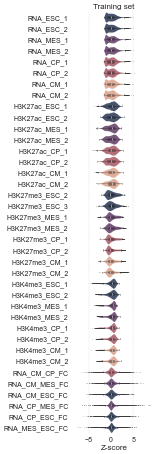

<Figure size 216x547.2 with 0 Axes>

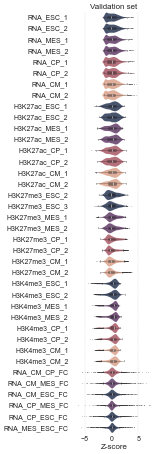

<Figure size 216x547.2 with 0 Axes>

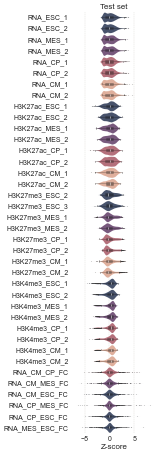

In [7]:
violins(X_train,COL_DICT=CT_COL_DICT, SAVEFIG=f'{DIR_FIG}/training_violins.png',X_LAB='Z-score',TITLE='Training set',SAT=0.7)
violins(X_val,COL_DICT=CT_COL_DICT, SAVEFIG=f'{DIR_FIG}/validation_violins.png',X_LAB='Z-score',TITLE='Validation set',SAT=0.7)
violins(X_test,COL_DICT=CT_COL_DICT, SAVEFIG=f'{DIR_FIG}/test_violins.png',     X_LAB='Z-score',TITLE='Test set',SAT=0.7)

In [8]:
def custom_loss(y_true, y_pred):
    # Cosine Similarity Loss
    cosine_loss = tf.keras.losses.CosineSimilarity(axis=1)(y_true, y_pred)
    
    # Mean Squared Error (MSE) Loss
    mse_loss = tf.keras.losses.MeanSquaredError()(y_true, y_pred)
    
    # Sum of Cosine Similarity and MSE
    combined_loss = cosine_loss + mse_loss
    
    return combined_loss

In [9]:
import keras_tuner

class MyAE(keras_tuner.HyperModel):
    def build(self, hp, return_individual_parts = False, N_FEATURES = X_train.shape[1], CODINGS_SIZE = CODINGS_SIZE, START_LR = 0.05):
            
        # Hyperparameter space
        ACT_FUN =           hp.Choice('ACT_FUN', ['selu','prelu','elu'], default='prelu')
        CODE_ACT_FUN =      'relu'

        if ACT_FUN =='prelu': ACT_FUN= None
        NUM_HLAYERS =       hp.Int('NUM_HLAYERS',         min_value=1, max_value=7, sampling='linear',default=2)
        NUM_NEURONS_SCALE = hp.Float('NUM_NEURONS_SCALE', min_value=1, max_value=2, sampling='linear', step=0.2, default=1.5)
        BATCH_NORM        = hp.Boolean('BATCH_NORM', default=True)
        #
        metrics = [tf.keras.metrics.CosineSimilarity(),tf.keras.metrics.RootMeanSquaredError() ]
        rec_loss = custom_loss
        # ----------------------------------------Encoder
        
        inputs = keras.layers.Input(shape=(N_FEATURES,), name='Input')
        x = keras.layers.Dense(N_FEATURES, activation=ACT_FUN, name='encoder_dense_0')(inputs)
        if ACT_FUN == None: 
            x = tf.keras.layers.PReLU(name='PReLU_0_E')(x)
        if BATCH_NORM:
            x = tf.keras.layers.BatchNormalization(name='encoder_batchnorm_0')(x)

        num_neurons_list = [N_FEATURES]  # Store the number of neurons for each layer in encoder
        num_neurons = N_FEATURES    
        
        for i in range(NUM_HLAYERS):
            num_neurons = max(CODINGS_SIZE*2, num_neurons // NUM_NEURONS_SCALE)  # Decrease the number of neurons linearly
            num_neurons_list.append(num_neurons)

            x = keras.layers.Dense(num_neurons, activation=ACT_FUN, name=f'encoder_dense_{i+1}')(x)
            if ACT_FUN == None: 
                x = tf.keras.layers.PReLU(name=f'PReLU_{i+1}_E')(x)
            if BATCH_NORM and i != NUM_HLAYERS-1:
                x = tf.keras.layers.BatchNormalization(name=f'encoder_batchnorm_{i+1}')(x)

        codings = keras.layers.Dense(CODINGS_SIZE, activation=CODE_ACT_FUN, name='encoder_codings')(x)
        encoder = keras.models.Model(inputs=[inputs], outputs=[codings], name='encoder')

        # ------------------------------------ Decoder
        
        decoder_inputs = keras.layers.Input(shape=[CODINGS_SIZE], name='decoder_input')
        x = keras.layers.Dense(num_neurons_list[-1], activation=ACT_FUN, name='decoder_dense_0')(decoder_inputs)
        if ACT_FUN == None: 
            x = tf.keras.layers.PReLU(name='PReLU_0_D')(x)
        if BATCH_NORM:
            x = tf.keras.layers.BatchNormalization(name='decoder_batchnorm_0')(x)

        for i in range(NUM_HLAYERS-1):
            num_neurons = num_neurons_list[-(i + 2)]
            
            x = keras.layers.Dense(num_neurons, activation=ACT_FUN, name=f'decoder_dense_{i+1}')(x)
            if ACT_FUN == None: 
                x = tf.keras.layers.PReLU(name=f'PReLU_{i+1}_D')(x)
            if BATCH_NORM:
                x = tf.keras.layers.BatchNormalization(name=f'decoder_batchnorm_{i+1}')(x)

        if ACT_FUN == None: 
            x = keras.layers.Dense(N_FEATURES, activation=ACT_FUN, name='decoder_dense_final')(x)
            outputs = tf.keras.layers.PReLU(name='decoder_prelu_final')(x)
        else:
            outputs = keras.layers.Dense(N_FEATURES, activation=ACT_FUN, name='decoder_output')(x)

        decoder = keras.models.Model(inputs=[decoder_inputs], outputs=[outputs], name='decoder')

        # Wrap Encoder and Decoder in an Autoencoder
        codings = encoder(inputs)
        reconstructions = decoder(codings)
        AE = keras.models.Model(inputs=[inputs], outputs=[reconstructions], name='autoencoder')
        AE.compile(loss=rec_loss, optimizer=keras.optimizers.Adam(learning_rate = START_LR), metrics=metrics)

        if return_individual_parts: return AE, encoder, decoder
        else : return AE

    
    def fit(self, hp, model, *args, **kwargs):
        return model.fit(
            *args,
            batch_size = hp.Int( "BATCH_SIZE", min_value=16, max_value=512, step=2, sampling="log"),
            **kwargs)
        

# Random Search

In [11]:
NUM_TRIALS = 500
BASEDIR = '../AE_tuning'
SUBDIR  = f'{MODEL_ID}_RandomSearch_{NUM_TRIALS}'
DIR = f'{BASEDIR}/{SUBDIR}'

tuner = keras_tuner.tuners.RandomSearch(
    MyAE(),
    objective = keras_tuner.Objective(name="val_loss", direction="min"),
    max_trials = NUM_TRIALS,  # Number of optimization iterations
    directory = BASEDIR,
    project_name = SUBDIR,
    seed = 42
)

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=14, verbose=1, min_delta=0, restore_best_weights=True)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=2, verbose=1, factor=0.5, min_lr=1e-8)
my_callbacks = [early_stop, reduce_lr]
# Perform hyperparameter tuning
with tf.device('/cpu:0'):
    tuner.search(X_train, X_train, 
                epochs=300, validation_data=(X_val, X_val), 
                callbacks=my_callbacks, )
#


Reloading Tuner from ../AE_tuning/AE_6D_ALL_X_FC_z_RandomSearch_500/tuner0.json
Metal device set to: 

2024-10-28 11:50:26.706026: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-10-28 11:50:26.706519: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



In [36]:
import json

def extract_json(DIR, NUM_TRIALS):
    """
    Extracts hyperparameter values and val_cosine_similarity from JSON files.

    Args:
        model_id: String representing the model identifier.
        num_trials: Integer representing the number of trials.
        trial_path: The path template for trial JSON files, containing placeholders
            for `{MODEL_ID}`, `{NUM_TRIALS}`, and `{i}`.

    Returns:
        A pandas DataFrame containing hyperparameter names as columns and
            corresponding values from each trial as rows. A 'val_cosine_similarity'
            column is also included.
    """
    data = []
    for i in range(NUM_TRIALS):
        
        # Format trial number string with leading zeros
        trial_str = f"{i:0>{len(str(NUM_TRIALS))}}"
        trial_path = f"{DIR}/trial_{trial_str}/trial.json"

        # Load data from JSON
        with open(trial_path, 'r') as f:
            trial_data = json.load(f)

            # Extract hyperparameter values
            hyperparameters = trial_data["hyperparameters"]["values"]
            # Extract val_loss
            try:
                val_loss = trial_data["metrics"]["metrics"]["val_loss"]["observations"][0]["value"][0]
            except KeyError:
                val_loss = None
            # Extract val_cosine_similarity
            try:
                val_cosine_similarity = trial_data["metrics"]["metrics"]["val_cosine_similarity"]["observations"][0]["value"][0]
            except KeyError:
                val_cosine_similarity = None
            # Extract val_rmse
            try:
                val_rmse = trial_data["metrics"]["metrics"]["val_root_mean_squared_error"]["observations"][0]["value"][0]
            except KeyError:
                val_rmse = None
            # Create a Series with trial number as index
            trial_data = pd.Series(hyperparameters, name=f"trial_{trial_str}")
            # Add val_loss, val_cosine_similarity, and val_rmse to the Series
            trial_data["val_loss"] = val_loss
            trial_data["val_cosine_similarity"] = val_cosine_similarity
            trial_data["val_rmse"] = val_rmse
            data.append(trial_data)
    # Combine trial data into a DataFrame
    df = pd.concat(data, axis=1).transpose()
    df.sort_values('val_cosine_similarity', ascending=False, inplace=True)
    try:
        df.to_csv(f'{DIR}/hp_table.results', mode='x')
    except FileExistsError:
        df.to_csv(f'{DIR}/hp_table_duplicate.results')
    return df

def plot_hyperparameter_distributions(df, DIR, TITLE='HPs distributions from XX'):
    # drop columns with name starting with 'val_
    hyperparameters = df.columns[~df.columns.str.startswith('val_')]
    
    n = len(hyperparameters)
    fig, axs = plt.subplots(1, n, figsize=(3*n, 3))
    plt.suptitle(TITLE, fontsize=20)
    for i, hyperparameter in enumerate(hyperparameters):
        sns.countplot(data=df, x=hyperparameter, ax=axs[i], color='grey')   
        sns.despine() 
        if i > 0:
            axs[i].set_ylabel('')
            
    plt.tight_layout()
    plt.savefig(f'{DIR}/HP_dist.pdf', format="pdf", bbox_inches="tight")
    
    
def plot_metrics_distributions(result_df, DIR, TITLE=f'Metrics on val. - RandomSearch ({NUM_TRIALS} trials)'):
    # Create a figure with 3 subplots in a column
    fig, axes = plt.subplots(3, 1, figsize=(4, 6), constrained_layout=True)
    plt.suptitle(TITLE, fontsize=18)
    # Plot val_cosine_similarity
    sns.histplot(result_df['val_cosine_similarity'], fill=True, bins=100, ax=axes[0],color='grey')
    axes[0].xaxis.grid(False)
    sns.despine(left=True, ax=axes[0])
    axes[0].set_xlim(-1, 1)
    axes[0].set_xlabel('Cosine similarity (Sc)')
    axes[0].set_ylabel('# Trials')
    #axes[0].set_title(TITLE)
    # Plot val_rmse
    sns.histplot(result_df['val_rmse'], fill=True, bins=100, ax=axes[1],color='grey')
    axes[1].xaxis.grid(False)
    sns.despine(left=True, ax=axes[1])
    axes[1].set_xlim(0, 1)
    axes[1].set_xlabel('RMSE')
    axes[1].set_ylabel('# Trials')
    # Plot val_loss
    sns.histplot(result_df['val_loss'], fill=True, bins=100, ax=axes[2],color='grey')
    axes[2].xaxis.grid(False)
    sns.despine(left=True, ax=axes[2])
    axes[2].set_xlabel('Loss')
    axes[2].set_ylabel('# Trials')
    # Save the figure
    plt.savefig(f'{DIR}/metrics_dist.pdf', format="pdf", bbox_inches="tight", dpi=300)


def plot_hp_values_loss(result_df, DIR, TITLE=f'Loss dis. per HPs values - RandomSearch ({NUM_TRIALS} trials)', SIZE=4, ALPHA=0.7):
    hyperparameters = [col for col in result_df.columns if not col.startswith('val')]
    result_df = result_df[result_df['val_loss']<1]
    # Set up the figure with subplots
    num_plots = len(hyperparameters)
    fig, axes = plt.subplots(1,num_plots, figsize=(3.5*num_plots,5), sharey=True)
    plt.suptitle(TITLE, fontsize=18)
    # Iterate over each hyperparameter and create a subplot
    for idx, hp in enumerate(hyperparameters):
        sns.boxplot(y='val_loss', x=hp, data=result_df, ax=axes[idx],
                    width=0.5,linewidth=1,showcaps=1,showfliers=True,
                    medianprops={"color": "w", "linewidth": 1},
                    boxprops=dict(facecolor="grey",alpha=1),
                    #whiskerprops=dict(color="black", alpha=0.4),
                    flierprops = dict(marker='.',markerfacecolor='grey', markersize=1,alpha=1)
                    );
    
        #sns.stripplot(y='val_loss', x=hp, data=result_df, ax=axes[idx], color='black',
        #                #palette='Spectral_r', hue='val_loss',
        #                legend=False,
        #                size=SIZE, alpha=ALPHA, )
        axes[idx].set_title(f'{hp}', fontsize=14)
        axes[idx].set_xlabel(f'')
        axes[idx].set_ylabel('val_loss', fontsize=12)
        sns.despine(bottom=True, )
        if hp == 'BETA':
            axes[idx].set_title(f'BETA (1e-x)', fontsize=14)

            
        
    plt.ylim(-1, 1)
    plt.tight_layout()
    plt.savefig(f'{DIR}/HP_values_val_loss.pdf', format="pdf", bbox_inches="tight",dpi=300)

In [13]:
result_df = extract_json(DIR, NUM_TRIALS)
result_df

,ACT_FUN,NUM_HLAYERS,NUM_NEURONS_SCALE,BATCH_NORM,BATCH_SIZE,val_loss,val_cosine_similarity,val_rmse
trial_126,prelu,1,1.0,True,64,-0.879724,0.947931,0.261164
trial_494,selu,1,1.2,False,64,-0.861099,0.947789,0.294431
trial_377,selu,2,1.0,True,128,-0.86428,0.947204,0.287965
trial_145,selu,1,1.4,False,32,-0.857638,0.94593,0.297141
trial_444,selu,1,1.4,False,128,-0.85595,0.9453,0.298914
...,...,...,...,...,...,...,...,...
trial_265,elu,6,1.4,True,256,None,None,None
trial_284,selu,5,1.6,True,16,None,None,None
trial_340,prelu,7,1.8,True,128,None,None,None
trial_352,elu,2,1.8,True,64,None,None,None


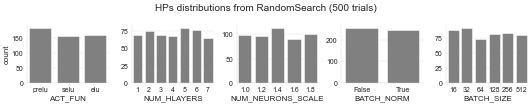

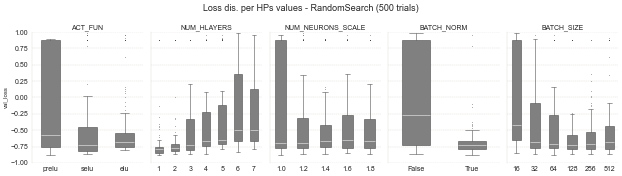

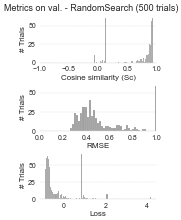

In [37]:

plot_hyperparameter_distributions(result_df,DIR,TITLE=f'HPs distributions from RandomSearch ({NUM_TRIALS} trials)')
plot_hp_values_loss(result_df, DIR, TITLE=f'Loss dis. per HPs values - RandomSearch ({NUM_TRIALS} trials)',SIZE=2, ALPHA=0.8)
plot_metrics_distributions(result_df, DIR, TITLE=f'Metrics on val. - RandomSearch ({NUM_TRIALS} trials)')


In [189]:
tuner.results_summary()

Results summary
Results in ../AE_tuning/AE_6D_ALL_X_FC_z_RandomSearch_500
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 126 summary
Hyperparameters:
ACT_FUN: prelu
NUM_HLAYERS: 1
NUM_NEURONS_SCALE: 1.0
BATCH_NORM: True
BATCH_SIZE: 64
Score: -0.8797243237495422

Trial 105 summary
Hyperparameters:
ACT_FUN: prelu
NUM_HLAYERS: 1
NUM_NEURONS_SCALE: 1.8
BATCH_NORM: True
BATCH_SIZE: 512
Score: -0.8690169453620911

Trial 287 summary
Hyperparameters:
ACT_FUN: prelu
NUM_HLAYERS: 2
NUM_NEURONS_SCALE: 1.2
BATCH_NORM: True
BATCH_SIZE: 512
Score: -0.8680441379547119

Trial 138 summary
Hyperparameters:
ACT_FUN: prelu
NUM_HLAYERS: 2
NUM_NEURONS_SCALE: 1.0
BATCH_NORM: True
BATCH_SIZE: 32
Score: -0.865947425365448

Trial 377 summary
Hyperparameters:
ACT_FUN: selu
NUM_HLAYERS: 2
NUM_NEURONS_SCALE: 1.0
BATCH_NORM: True
BATCH_SIZE: 128
Score: -0.8642796277999878

Trial 494 summary
Hyperparameters:
ACT_FUN: selu
NUM_HLAYERS: 1
NUM_NEURONS_SCALE: 1.2
BATCH_NORM: False
BATCH_SIZE: 

In [190]:

best_hp = tuner.get_best_hyperparameters()[0]
best_AE, best_encoder, best_decoder = MyAE().build(best_hp, return_individual_parts=True)
best_encoder.summary()
best_decoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 38)]              0         
                                                                 
 encoder_dense_0 (Dense)     (None, 38)                1482      
                                                                 
 PReLU_0_E (PReLU)           (None, 38)                38        
                                                                 
 encoder_batchnorm_0 (BatchN  (None, 38)               152       
 ormalization)                                                   
                                                                 
 encoder_dense_1 (Dense)     (None, 38)                1482      
                                                                 
 PReLU_1_E (PReLU)           (None, 38)                38        
                                                           